# Official stations data

In this notebook, we will assemble a time series of meteorological measurements from meteorological stations in the study region. We will follow these steps:
1. Given a target year, use the Agrometeo API to select the temporal range of interest as the hottest heatwave, defined as follows: the hottest (based on mean temperature) period of at least 3 consecutive days with an average temperature over 27$^{\circ}$C (namely, the hottest period of level 4 warning days [according to the heat warning level definitions by MeteoSwiss](https://www.meteoswiss.admin.ch/weather/weather-and-climate-from-a-to-z/heat-warnings.html)).
2. Given the temporal range of interest obtained above, download the time series of meteorological measurements from the other official meteorological stations in the study region.
3. Resample all data to hourly resolution, assemble into a single long data frame and dump into a file

In [ ]:
import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from meteora import utils as meteora_utils
from meteora.clients import AgrometeoClient

from uhi_cws_lausanne import plot_utils

figwidth, figheight = plt.rcParams["figure.figsize"]

HEATWAVE_N_CONSECUTIVE_DAYS = 3
HEATWAVE_THRESHOLD = 25

In [ ]:
# spatial extent
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"

# official data downloaded manually (or obtained via email)
official_ts_df_filepath = "../data/raw/official-ts-df.csv"
official_stations_gdf_filepath = "../data/raw/official-stations.gpkg"

# files to write
dst_ts_df_filepath = "../data/interim/official-ts-df.csv"
dst_stations_gdf_filepath = "../data/interim/official-stations.gpkg"

# select study period
start_year = 2023
end_year = 2023
# months to consider when querying the Agrometeo API
start_month = 5
end_month = 9


# date format for heatwave labels
STRFMT = "%Y/%m/%d"

## 1. Select study period

We will use the Agrometeo API to select the hottest heatwave period as described above.

In [ ]:
# select only land extent (agglom_extent_filepath has two geometries: land and lake)
region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]

# download data
agrometeo_client = AgrometeoClient(region=region)
agrometeo_ts_df = pd.concat(
    [
        agrometeo_client.get_ts_df(
            "temperature",
            datetime.date(year, start_month, 1),
            datetime.date(year, end_month, 30),
            scale="hour",
        )
        for year in range(start_year, end_year + 1)
    ],
    axis="rows",
)
# convert to wide form
agrometeo_ts_df = meteora_utils.long_to_wide(agrometeo_ts_df)
# use station names rather than ids
agrometeo_ts_df = agrometeo_ts_df.rename(columns=agrometeo_client.stations_gdf["name"])

# find consecutive days above threshold
day_mean_ts_ser = (
    agrometeo_ts_df.groupby(agrometeo_ts_df.index.date).mean().mean(axis="columns")
)
idx = (day_mean_ts_ser >= HEATWAVE_THRESHOLD).rolling(
    window=HEATWAVE_N_CONSECUTIVE_DAYS, center=True
).sum() >= HEATWAVE_N_CONSECUTIVE_DAYS
idx = idx | idx.shift(1) | idx.shift(-1)

heatwave_max_ser = pd.concat(
    [
        pd.Series(day_mean_ts_ser.loc[g[g].index].mean(), index=g.index)
        for i, g in idx.groupby(idx.ne(idx.shift()).cumsum())
        if g.any()
    ]
)
date_ser = pd.to_datetime(heatwave_max_ser.rename_axis("time").reset_index()["time"])
heatwave_range_df = date_ser.groupby(date_ser.diff().dt.days.ne(1).cumsum()).agg(
    start="first", end="last"
)
# add a day in the end to ensure that we get the data from the start of the first day to
# the end of the last day
heatwave_range_df["end"] = heatwave_range_df["end"] + datetime.timedelta(days=1)
# show the data frame
# heatwave_range_df

# add heatwave id as outermost index
agrometeo_ts_df = (
    pd.concat(
        [
            agrometeo_ts_df.loc[start:end]
            .iloc[:-1]
            .assign(
                **{
                    "heatwave": "-".join(
                        [
                            f"{date.strftime(STRFMT)}"
                            for date in [start, end - datetime.timedelta(days=1)]
                        ]
                    )
                }
            )
            for start, end in heatwave_range_df.itertuples(index=False)
        ]
    )
    .reset_index()
    .set_index(["heatwave", "time"])
)
agrometeo_ts_df.head()

station_id                                 PULLY  MARCELIN  BOURG-EN-LAVAUX
heatwave              time                                                 
2023/07/09-2023/07/11 2023-07-09 00:00:00   23.4      22.1             24.4
                      2023-07-09 01:00:00   22.8      22.0             23.9
                      2023-07-09 02:00:00   22.2      21.4             22.0
                      2023-07-09 03:00:00   21.3      18.7             21.6
                      2023-07-09 04:00:00   20.7      18.2             20.8

## 2. Get data from other official stations

This data has been manually-obtained for the study period, e.g., via IDAWEB (MeteoSwiss, FEDRO, WSL) and via email for Vaud'air:

In [ ]:
other_ts_df = pd.read_csv(
    official_ts_df_filepath, index_col=["heatwave", "time"], parse_dates=["time"]
)
other_ts_df.head()

NABLAU        PUY     WSLLAF  \
heatwave              time                                                   
2023/07/09-2023/07/11 2023-07-09 00:00:00  23.150000  22.216667  22.400000   
                      2023-07-09 01:00:00  22.266667  21.383333  21.616667   
                      2023-07-09 02:00:00  22.050000  20.833333  20.733333   
                      2023-07-09 03:00:00  21.750000  20.566667  19.283333   
                      2023-07-09 04:00:00  21.366667  20.050000  18.983333   

                                           VD_Lausanne_PdL  VD_Bussigny  \
heatwave              time                                                
2023/07/09-2023/07/11 2023-07-09 00:00:00          22.3005      21.6855   
                      2023-07-09 01:00:00          21.6280      21.6415   
                      2023-07-09 02:00:00          20.9205      20.9055   
                      2023-07-09 03:00:00          20.4510      20.5430   
                      2023-07-09 04:00:00          19.9885      19.5435   

                                           VD_Morges  Nabel_Lausanne  
heatwave              time                                            
2023/07/09-2023/07/11 2023-07-09 00:00:00    24.2400       24.100209  
                      2023-07-09 01:00:00    23.6190       23.468221  
                      2023-07-09 02:00:00    22.9725       22.930736  
                      2023-07-09 03:00:00    22.2725       22.200319  
                      2023-07-09 04:00:00    21.4885       22.045598

## 3. Filter heatwaves period, resample and assemble

In [ ]:
official_ts_df = pd.concat([agrometeo_ts_df, other_ts_df], axis="columns")

Let us now plot, for each heatwave, the hourly temperature averaged over stations and days of the heatwave:

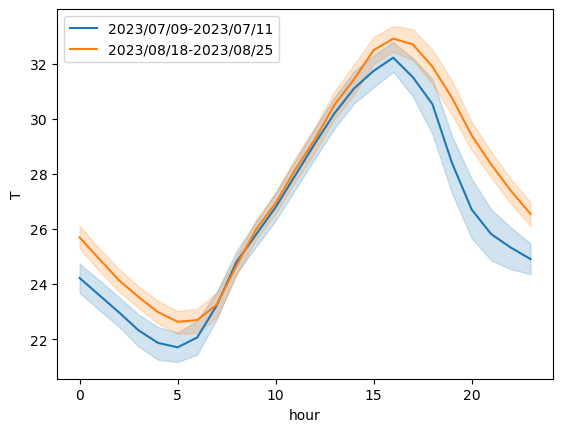

In [ ]:
fig, ax = plt.subplots()

for heatwave, heatwave_ts_df in official_ts_df.groupby(level="heatwave"):
    heatwave_ts_df = heatwave_ts_df.stack(future_stack=True).reset_index(name="T")
    sns.lineplot(
        heatwave_ts_df.assign(**{"hour": heatwave_ts_df["time"].dt.hour}),
        x="hour",
        y="T",
        ax=ax,
        label=heatwave,
    )

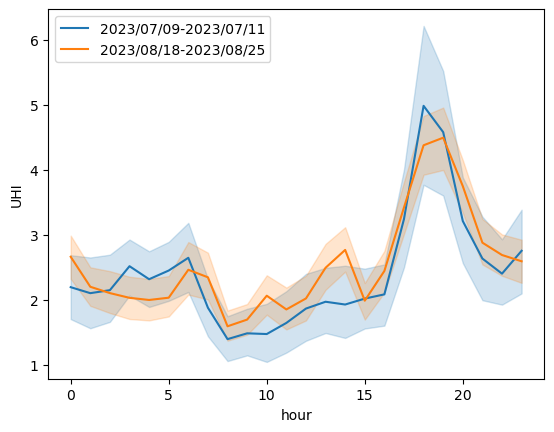

In [ ]:
fig, ax = plt.subplots()

for heatwave, heatwave_ts_df in official_ts_df.apply(
    lambda row: row - min(row), axis="columns"
).groupby(level="heatwave"):
    heatwave_ts_df = heatwave_ts_df.stack(future_stack=True).reset_index(name="UHI")
    sns.lineplot(
        heatwave_ts_df.assign(**{"hour": heatwave_ts_df["time"].dt.hour}),
        x="hour",
        y="UHI",
        ax=ax,
        label=heatwave,
    )

## 4. Station locations

In [ ]:
official_stations_gser = gpd.read_file(official_stations_gdf_filepath).set_index(
    "station_id"
)
official_stations_gser = pd.concat(
    [
        official_stations_gser,
        agrometeo_client.stations_gdf.set_index("name")["geometry"].to_crs(
            official_stations_gser.crs
        ),
    ]
)["geometry"]

<Axes: >

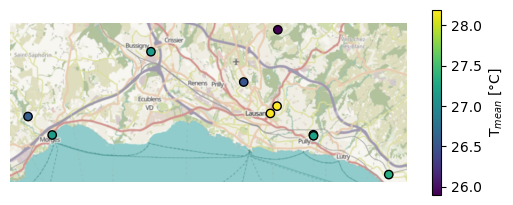

In [ ]:
# plot by average temperature
plot_kwargs = {"legend_kwds": {"shrink": 0.5, "label": "T$_{mean}$ [$\degree$C]"}}
plot_utils.plot_map_by_var(
    official_stations_gser, official_ts_df.mean().rename("T_mean"), **plot_kwargs
)

## 4. Filter data and dump to files

In [ ]:
# stations to keep: stations from the time series data and within the extent
official_stations = official_stations_gser.index.intersection(official_ts_df.columns)
# filter time series data from stations of the region only
official_ts_df[official_stations].to_csv(dst_ts_df_filepath)
# filter to keep only stations in our time series data frame
official_stations_gser.loc[official_stations].to_file(dst_stations_gdf_filepath)